In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

# Coding Data Importing:

In [2]:
# Import the Coding Spreadsheet
data = pd.read_csv('FinalCoding.csv',encoding='utf-8')
raw = data[data['Final Check: Keep-1,Drop-0']==1]
raw.reset_index(drop=True, inplace=True)

#Uncomment below lines to see the detailed information about the code variables.
'''
def colNameDict(dataframe):
    colDic = {'C'+str(i): column_name for i, column_name in enumerate(dataframe.columns)}
    return colDic
print(colNameDict(raw))
'''


"\ndef colNameDict(dataframe):\n    colDic = {'C'+str(i): column_name for i, column_name in enumerate(dataframe.columns)}\n    return colDic\nprint(colNameDict(raw))\n"

In [3]:
#Set up Indicator Data Frames -- WHO, WHAT, HOW, WHEN, BASIC

BASIC = raw.iloc[:, [2,5,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
WHO = raw.iloc[:, 35:40]
WHAT = raw.iloc[:, 40:50]
HOW = raw.iloc[:, 50:66]
WHEN = raw.iloc[:, [66,67]]

simpleBasicColName = ['Id','VIS year','Domain','Domain-2nd','Domain-manually','Data-Driven','Eval.Mentioned','Eval.Inte','Std.Protocal','DReq','DReq.w.Expt','App.','Dom.Inte','VIS4AI','AI4VIS','XR','N.o.Session']
simpleWhoColName = ['Tot.No.','Expertise.1','no.1','Expertise.2','no.2']
simpleWhatColName = ['UWP','VADR','CTV','CDA','UP','UE','AP','QRI','ESG','EUV']
simpleHowColName = ['Obs','Wshp','FGrp', 'Tap', 'Int','SnQ', 'Tsk_Ql','IwT', 'CntAn','ExpFdbk', 'CStudy','CExp','AB', 'PerfEval', 'Tsk_Qn','UsrBA']
simpleWhenColName = ['When','IteraRefine']

BASIC.columns = simpleBasicColName
WHO.columns = simpleWhoColName
WHAT.columns = simpleWhatColName
HOW.columns = simpleHowColName
WHEN.columns = simpleWhenColName

# Selection of VIS application research papers:

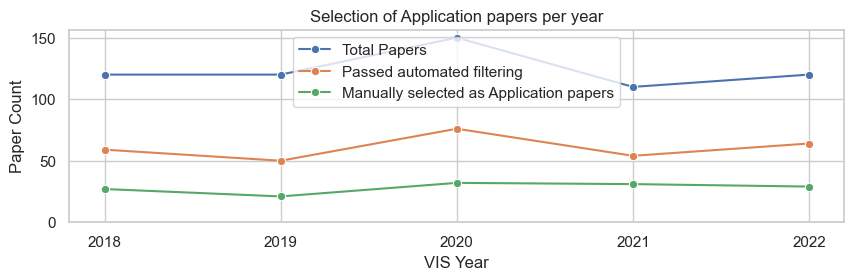

In [4]:
#Plot of number of IEEE VIS papers per year, and how many were selected in our study as application papers.

total_per_year = [120, 120, 150, 110, 120]
#Total number of IEEE VIS papers per year from 2018 to 2022
automated_filtering = data.iloc[:,[5,19]].dropna(inplace=False)
#Number of papers in the .csv data file, filtered from the total via algorithm.
manual_filtering = automated_filtering[automated_filtering['Final Check: Keep-1,Drop-0']==1]
#Number of papers ultimately selected for observation in the study.

filtering_data = pd.DataFrame()
filtering_data['VIS year'] = [2018, 2019, 2020, 2021, 2022]
filtering_data['Total papers'] = total_per_year
filtering_data['Automated filtering'] = automated_filtering.groupby('VIS Presenting Year').count().reset_index().iloc[:,1]
filtering_data['Manual filtering'] = manual_filtering.groupby('VIS Presenting Year').count().reset_index().iloc[:,1]

sns.set(style="whitegrid")
years_to_display = filtering_data['VIS year']

plt.figure(figsize=(10, 2.5))
sns.lineplot(x='VIS year', y='Total papers', data=filtering_data, label='Total Papers', marker='o')
sns.lineplot(x='VIS year', y='Automated filtering', data=filtering_data, label='Passed automated filtering', marker='o')
sns.lineplot(x='VIS year', y='Manual filtering', data=filtering_data, label='Manually selected as Application papers', marker='o')
plt.ylim(0)
plt.xlabel('VIS Year')
plt.ylabel('Paper Count')
plt.title('Selection of Application papers per year')
plt.xticks(years_to_display)  
plt.legend()
plt.grid(True)

plt.show()

# Analyze the relationship within and between the WHAT and HOW sets:

In [5]:
#Correlation Heatmap

def drawCorrHeatmap(df):
    # Calculate correlation matrix
    correlation_matrix = df.corr().fillna(0)

    # Generate Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.2)
    plt.title('Correlation Heatmap')
    plt.show()

## Objective 1: analyze the correlation between the variables in the WHAT set and HOW set separately: 

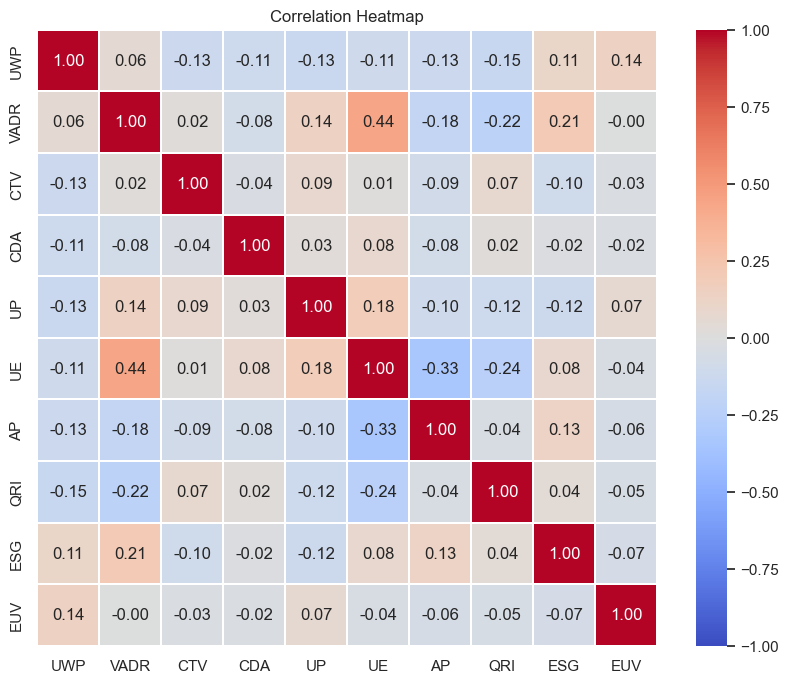

In [6]:
# Relationships between variables in the WHAT set.
drawCorrHeatmap(WHAT)


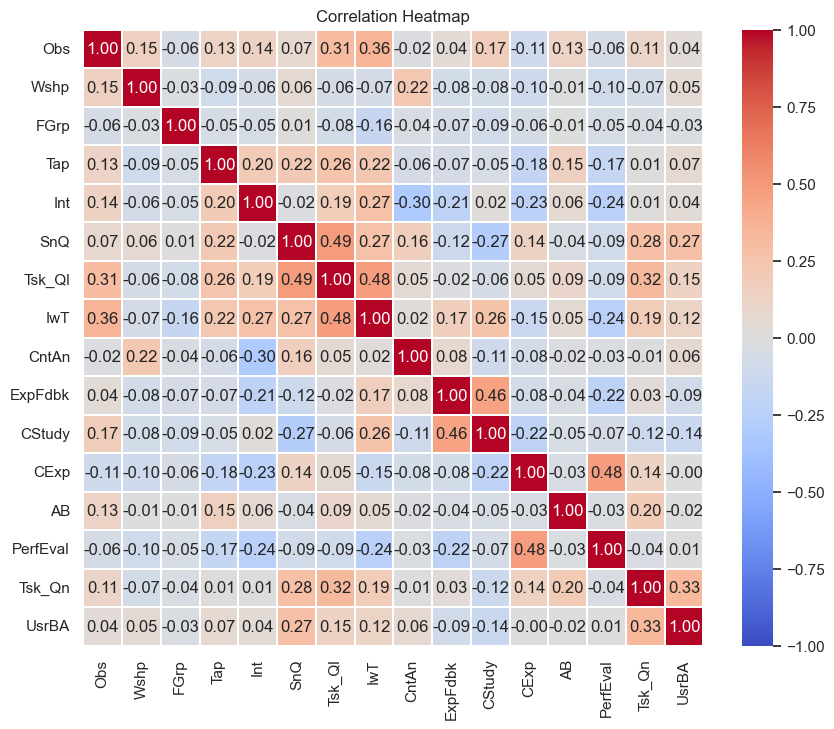

In [7]:
# Relationships between variables in the HOW set.
drawCorrHeatmap(HOW)

## Objective 2: analyze the association between the WHAT set and the HOW set,by looking at the frequent itemsets in each of the two datasets, and apply the association rules to find our the associated itemsets 

In [8]:
#Association Rules -- calculate the association between items in the WHAT Set & HOW Set:
# 1) within HOW; 2) within WHAT; 3) within HOW&WHAT, HOW->WHAT as antecidents and dependents, calculate the frequent itemsets

def getAssociationItemsets(df,min_support, min_threshold,output_frequentItemsets,output_rules):
    # A priori Algothrim to find frequent itemsets
    df.fillna(0, inplace=True)
    df = df.astype(int)
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    frequent_itemsets.sort_values(by='support', ascending=False, inplace=True )
    # Detect the association rules using the 'lift' metric
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold)
    rules.sort_values(by='lift', ascending=False, inplace=True )

    #"support", measuring the frequency of itemset occurrences. When choosing this metric, you can identify itemsets that appear frequently.
    #"confidence", measuring the reliability of rules. When choosing this metric, you can discover rules with high confidence.
    #"lift", measuring the degree of improvement of rules relative to random occurrence. When choosing this metric, you can find rules that are independent of randomness.

    result = {'frequent_itemsets':frequent_itemsets, 'rules':rules}
    # Output to .csv file
    frequent_itemsets.to_csv(output_frequentItemsets, index=False, header=True)
    rules.to_csv(output_rules, index=False, header=True)
    
    return (result)


In [9]:
#Calculate association & frequent itemsets within How set
withinHOW = getAssociationItemsets(HOW,min_support=0.2, min_threshold=1.0, output_frequentItemsets='how_frequentItemsets.csv',output_rules='how_associationRules.csv')

In [10]:
#Calculate association & frequent itemsets within WHAT set
withinWHAT=getAssociationItemsets(WHAT,min_support=0.2, min_threshold=1.0, output_frequentItemsets='what_frequentItemsets.csv',output_rules='what_associationRules.csv')

In [11]:
#WHAT & HOW concat 
what_how = pd.concat([WHAT,HOW], axis = 1)
what_how_rules = getAssociationItemsets(what_how,min_support=0.2, min_threshold=1,output_frequentItemsets='what&how_frequentItemsets.csv',output_rules='what&how_associationRules.csv')['rules']

In [12]:
# Only consider itemsets and antecedent&concequent pair that meet real logic--the association between WHAT items (itemsets) & HOW items (itemsets),
# process the data: 1) delete all the antecedents-consequents pairs that only contains variables from the samme set (either HOW or WHAT),
# 2) combine itemsets with the same, redefine antecedents and consequents as WHAT and HOW,
# Visualize the result using 1) Heatmap, 2) Network graph

# refine the antecident and dependent sets with logic WHAT -> HOW:
item_dataset_mapping = {
    'UWP':'WHAT','VADR':'WHAT','CTV':'WHAT','CDA':'WHAT','UP':'WHAT','UE':'WHAT','AP':'WHAT','QRI':'WHAT','ESG':'WHAT','EUV':'WHAT',
    'Obs':'HOW','Wshp':'HOW','FGrp':'HOW', 'Tap':'HOW', 'Int':'HOW','SnQ':'HOW', 'Tsk_Ql':'HOW','IwT':'HOW', 'CntAn':'HOW','ExpFdbk':'HOW', 'CStudy':'HOW', 
                 'CExp':'HOW','AB':'HOW', 'PerfEval':'HOW', 'Tsk_Qn':'HOW','UsrBA':'HOW'
}

rules4VIS = what_how_rules.iloc[1::2,[0,1,6]] # delete itemsets with the same items but might in a converse antecedent-consequent order, leave attributes 'antecedents', 'consequents', and 'lift'
for index, row in rules4VIS.iterrows():
    antecedent_items = set(row['antecedents'])
    consequent_items = set(row['consequents'])
    comb_items = antecedent_items | consequent_items
    
    what_set = set()
    how_set = set()

    for item in comb_items:
        dataset = item_dataset_mapping.get(item, None)
        if dataset == 'WHAT':
            what_set.add(item)
        elif dataset == 'HOW':
            how_set.add(item)
    
    # update antecedents and consequents columns
    rules4VIS.at[index, 'antecedents'] = what_set
    rules4VIS.at[index, 'consequents'] = how_set

rules4VIS = rules4VIS[(rules4VIS['antecedents'].apply(len) != 0) & (rules4VIS['consequents'].apply(len) != 0)]

In [13]:
#Association Heatmap: 
def set_to_str(s):
    return ', '.join(s)

def drawAssoRulesHeatmap(set_to_str, df=rules4VIS):
    # antecedents and consequents columns -- change data type from 'set' to 'str'
    result_df = df.copy()
    result_df['antecedents'] = df['antecedents'].apply(set_to_str)
    result_df['consequents'] = df['consequents'].apply(set_to_str)

    result_df = result_df.groupby(['antecedents', 'consequents'])['lift'].agg('mean').reset_index()

    result_df = result_df.pivot(index='antecedents', columns='consequents', values='lift').fillna(0)

    # Create Heatmap
    plt.figure(figsize=(15, 3))
    heatmap = sns.heatmap(result_df, annot=True, cmap='BuPu', fmt='.2f', cbar=True)

    # Title and labels
    plt.title('Association Rules Lift Heatmap')
    plt.xlabel('Consequents')
    plt.ylabel('Antecedents')

    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.show()
    
    return (result_df)

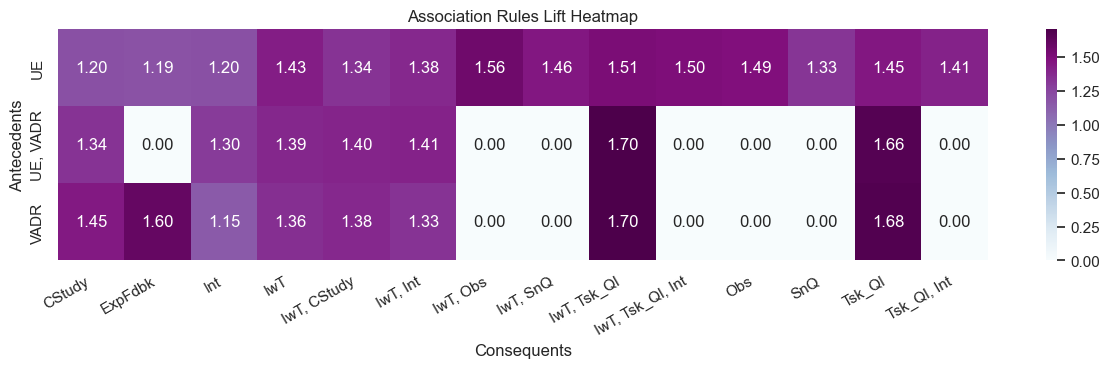

In [14]:
ARHeatmap = drawAssoRulesHeatmap(set_to_str, df=rules4VIS)

In [15]:
# Association Network Graph

def drawAssoRulesNetwork(df=rules4VIS, mypos=1):
    G = nx.Graph()

    for idx, row in df.iterrows():
        antecedents = frozenset(row['antecedents'])
        consequents = frozenset(row['consequents'])
        lift = round(row['lift'], 2)  

        antecedents_str = ', '.join(antecedents)
        consequents_str = ', '.join(consequents)
        
        if antecedents_str not in G:
            G.add_node(antecedents_str, label=antecedents_str, color='lightblue', size=3)
        if consequents_str not in G:
            G.add_node(consequents_str, label=consequents_str, color='pink', size=1.5)
        
        G.add_edge(antecedents_str, consequents_str, weight=lift)

    node_colors = [G.nodes[node]['color'] for node in G.nodes]
    node_sizes = [G.nodes[node]['size'] * 300 for node in G.nodes]

    cmap = plt.cm.coolwarm

    weights = [G.edges[edge]['weight'] for edge in G.edges]
    weights_normalized = [(w - min(weights)) / (max(weights) - min(weights)) for w in weights]

    dpi = 200 
    fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)

    posDict = {1:nx.spring_layout(G),
               2:nx.random_layout(G),
               3:nx.shell_layout(G),
               4:nx.circular_layout(G)}   
    pos=posDict[mypos]
    nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85, with_labels=False, width=1.5, edge_color=weights_normalized, edge_cmap=cmap)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_color='black')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', fraction=0.02, pad=-0.01, ax=ax)
    cbar.set_label('Lift')

    plt.title('Association Rules Network')

    plt.axis('off')
    plt.tight_layout()
    plt.show()


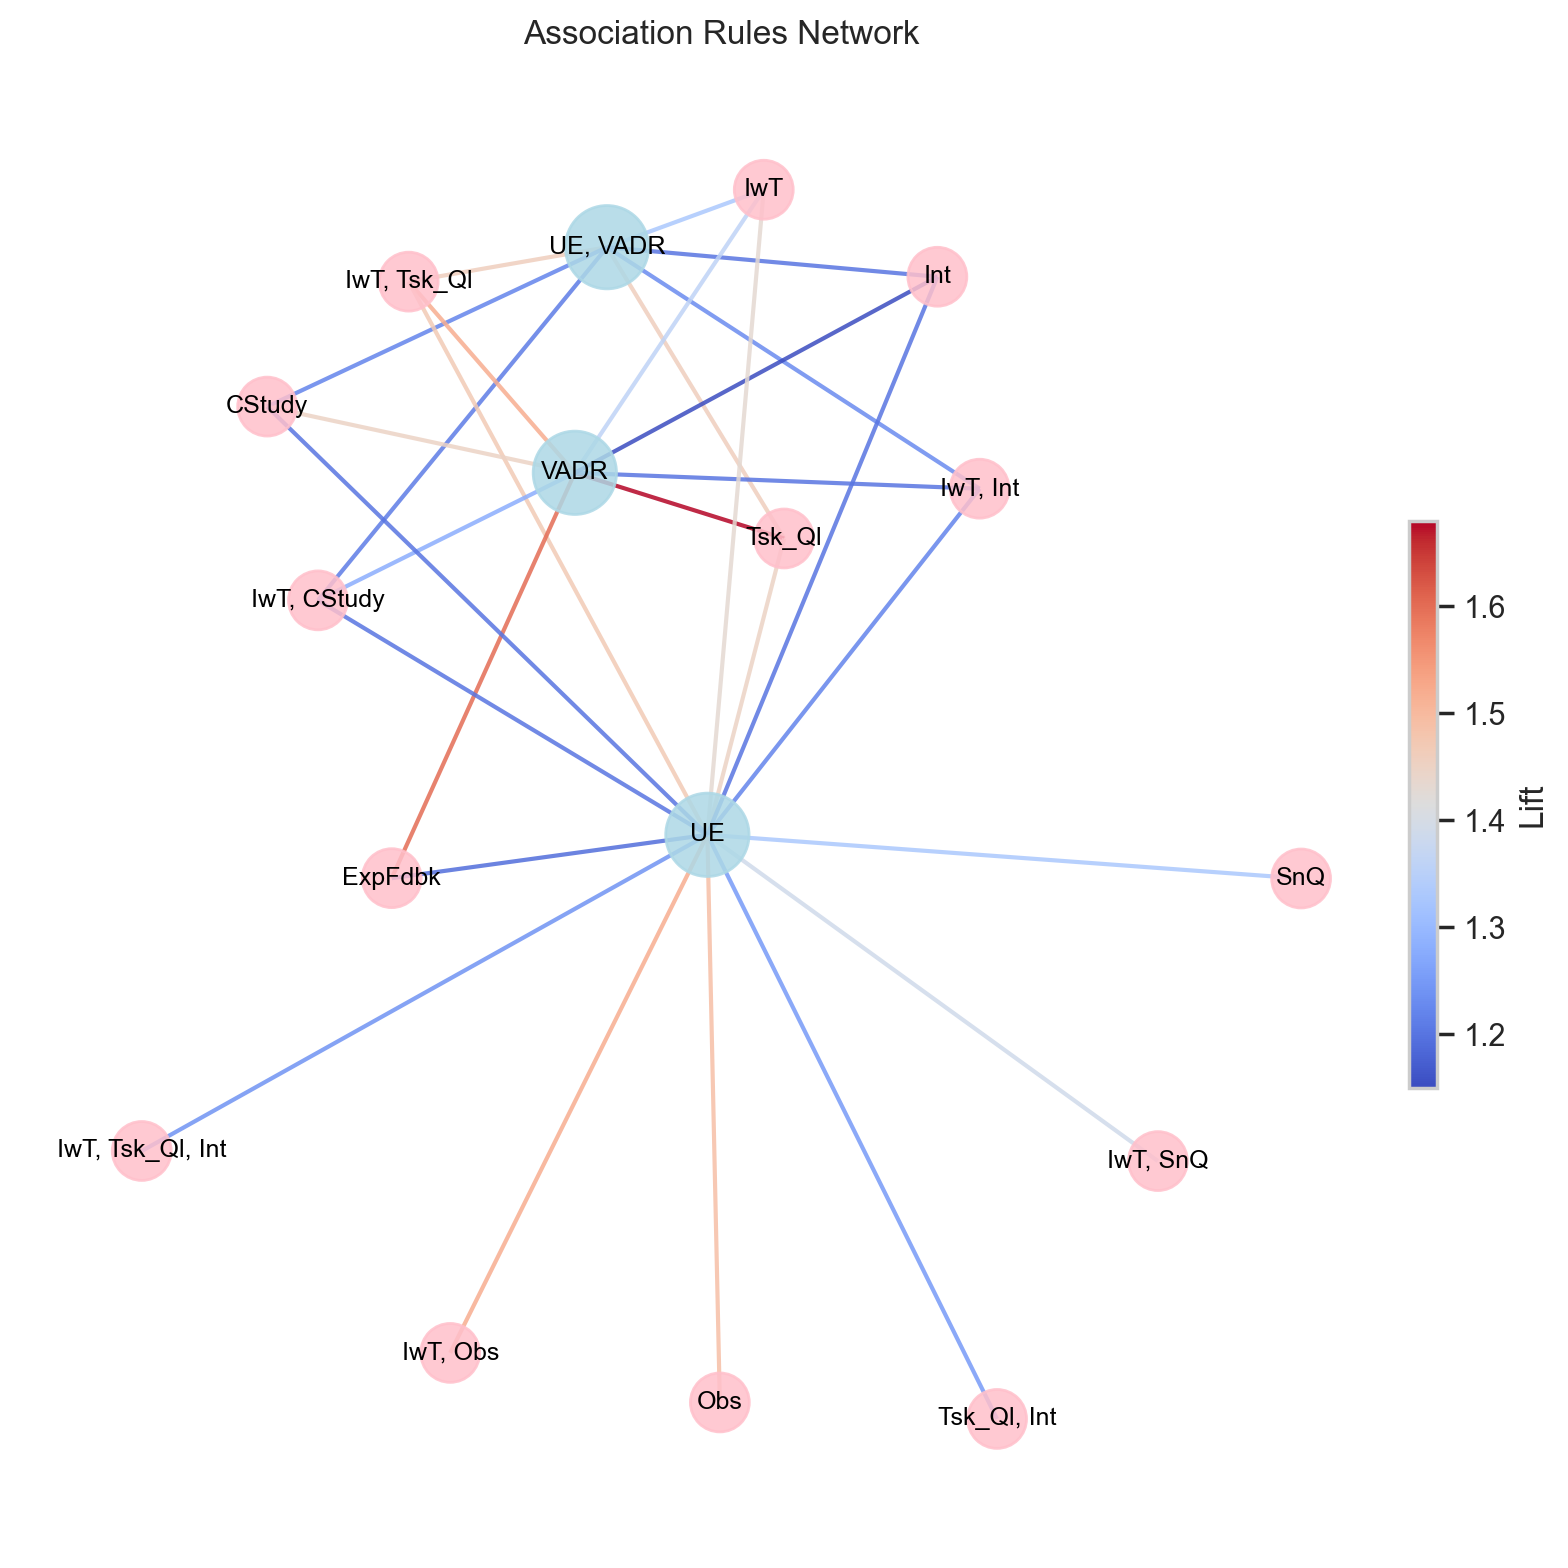

In [16]:
ARNetwork = drawAssoRulesNetwork(df=rules4VIS, mypos=1)

# Analyze the Domain impact:
## Apply Logistic-regression and ANOVA to analyze the difference in the X variables with different y variables (the impcat of different y in X)
## The practice meaning of y and X in different case:
### Y: 1. domain-driven or problem-driven
###    2. different domain: domain 1-18
###    3. AI--(AI4VIS or VIS4AI) or non-AI
###    4. VR or non-VR
### X: WHAT+WHO+HOW+WHEN 

In [17]:
# convert the who data from one column to multi columns, generate new WHO set as WHO2
WHO2 = pd.DataFrame(columns=['DExpt', 'DUser', 'GenPub', 'VExpt', 'NoPtcp'])
#newWHO = pd.concat([WHO, WHO2], axis = 1).fillna(0)

def convertExpertise(row, expertise_category):
    if row['Expertise.1'] == expertise_category:
        if expertise_category == '5. no participant':
            return 1
        else:
            if row['no.1'] == 'not specified':
                return 1
            else:
                return row['no.1']
    elif row['Expertise.2'] == expertise_category:
        if expertise_category == '5. no participant':
            return '1'
        else:
            return row['no.2']
    else:
        return 0


In [18]:
WHO2['DExpt'] = WHO.apply(lambda row: convertExpertise(row, '1. domain expert'), axis=1)
WHO2['DUser'] = WHO.apply(lambda row: convertExpertise(row, '2. domain user'), axis=1)
WHO2['GenPub'] = WHO.apply(lambda row: convertExpertise(row, '3. general public'), axis=1)
WHO2['VExpt'] = WHO.apply(lambda row: convertExpertise(row, '4. visual expert'), axis=1)
WHO2['NoPtcp'] = WHO.apply(lambda row: convertExpertise(row, '5. no participant'), axis=1)
WHO2.astype(int)

,DExpt,DUser,GenPub,VExpt,NoPtcp
0,2,0,0,0,0
1,0,0,0,0,1
2,4,0,0,0,0
3,0,0,0,0,1
4,2,0,0,0,0
...,...,...,...,...,...
219,2,0,0,0,0
220,9,0,0,0,0
221,9,0,0,0,0
222,1,0,0,0,0


In [19]:
WHEN2 = pd.DataFrame(columns=['Bf_gen', 'Bf_design', 'Bf_develop', 'Af'])
def convertWhen(row, when_category):
    if row['When'] == when_category:
            return '1'
    else:
        return 0

In [20]:
WHEN2['Bf_gen'] = WHEN.apply(lambda row: convertWhen(row, '1. Before the deployment (General)'), axis=1)
WHEN2['Bf_design'] = WHEN.apply(lambda row: convertWhen(row, '2. Before the deployment (Before or during design phase ONLY)'), axis=1)
WHEN2['Bf_develop'] = WHEN.apply(lambda row: convertWhen(row, '3. Before the deployment (During the development and refinement phrase ONLY)'), axis=1)
WHEN2['Af'] = WHEN.apply(lambda row: convertWhen(row, '4. After the deployment'), axis=1)
WHEN2.astype(int)

,Bf_gen,Bf_design,Bf_develop,Af
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
219,0,0,1,0
220,1,0,0,0
221,0,0,0,1
222,0,0,0,1


In [21]:
# Generate two types of datasets from the raw set, aiming to 1) combine the multi entries(multiple evaluation sessions) in one paper,or 2) fill all the blank columns in the BASIC part for all the added entries for each paper. 
#WholeSets = pd.concat([BASIC, WHO2, WHAT,HOW,WHEN2], axis = 1)

# ExtendSet
# group BASIC set by Id, coose the first entry of each group
first_records = BASIC.groupby('Id').first().reset_index()
# fill out the black columns
filled_df = BASIC.groupby('Id').apply(lambda group: group.fillna(group.iloc[0])).reset_index(drop=True).fillna(0)
#set up the filled whole set
filledWhole = pd.concat([filled_df, WHO2.astype(int),WHAT.astype(int),HOW.astype(int),WHEN2.astype(int)], axis = 1)

# CombSet
temp = pd.concat([filled_df['Id'],WHO2.astype(int),WHAT.astype(int),HOW.astype(int),WHEN2.astype(int)], axis = 1)
summed_df = temp.groupby('Id').sum().reset_index()

# reset index and inplace
summed_df.reset_index(drop=True, inplace=True)

strimmedWhole = pd.concat([first_records,summed_df.iloc[:,1:36]], axis = 1)




In [22]:
#set y and X
y_domain_data = strimmedWhole['Data-Driven'].astype('category')
y_domain = strimmedWhole['Domain'].fillna('Unknown').astype('category')
y_AI4VIS = strimmedWhole['AI4VIS'].astype('category')
y_VIS4AI = strimmedWhole['VIS4AI'].astype('category')
y_XR = strimmedWhole['XR'].astype('category')

X = strimmedWhole.iloc[:,17:53]

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# validate the covariance in the dataset
# VIF metric is used to detect the covariance. Usually if the variable's VIF >=20, it is considered to be have high covariance.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


    VIF Factor
0     3.304834
1     2.324469
2     2.836168
3     1.350797
4     4.695503
5     3.916713
6     6.586710
7     2.008457
8     2.191544
9     3.146299
10   16.019700
11    5.060344
12    2.599732
13    2.325004
14    1.713184
15    2.565068
16    2.890144
17    1.522308
18    2.100918
19    6.901324
20    4.488220
21    5.350323
22   19.358210
23    2.515020
24    2.820548
25    5.773361
26    3.597845
27    1.477905
28    4.672425
29    2.143405
30    2.311596
31    2.295347
32    5.407458
33    3.713243
34   32.655851


In [24]:
def calculateDiff(y,X):
    X = sm.add_constant(X)

    # set up the logistic regression model, apply L1 (Lasso) Normalization to reduce the Covariance in the model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit_regularized(method='l1', alpha=0.05)

    print(result.summary())

    return(result)

In [25]:
# Y: 1) domain-driven or problem-driven ~ X: WHAT+WHO+HOW+WHEN 

result1 = calculateDiff(y_domain_data,X)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.42379264828294744
            Iterations: 290
            Function evaluations: 294
            Gradient evaluations: 290
                           Logit Regression Results                           
Dep. Variable:            Data-Driven   No. Observations:                  140
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                           33
Date:                Sun, 08 Oct 2023   Pseudo R-squ.:                  0.3294
Time:                        23:57:24   Log-Likelihood:                -57.910
converged:                       True   LL-Null:                       -86.351
Covariance Type:            nonrobust   LLR p-value:                  0.006035
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [26]:
# Y: 3) AI--(AI4VIS and VIS4AI) or non-AI
# 3.1) AI4VIS or non-AI ~ X: WHAT+WHO+HOW+WHEN
result3_1 = calculateDiff(y_AI4VIS,X)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.20227078704826773
            Iterations: 431
            Function evaluations: 438
            Gradient evaluations: 431
                           Logit Regression Results                           
Dep. Variable:                 AI4VIS   No. Observations:                  140
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                           32
Date:                Sun, 08 Oct 2023   Pseudo R-squ.:                  0.5840
Time:                        23:57:24   Log-Likelihood:                -23.887
converged:                       True   LL-Null:                       -57.416
Covariance Type:            nonrobust   LLR p-value:                 0.0002786
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [27]:
# 3.2) VIS4AI or non-AI ~ X: WHAT+WHO+HOW+WHEN
result3_2 = calculateDiff(y_VIS4AI,X)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3972172675661355
            Iterations: 297
            Function evaluations: 302
            Gradient evaluations: 297
                           Logit Regression Results                           
Dep. Variable:                 VIS4AI   No. Observations:                  140
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                           34
Date:                Sun, 08 Oct 2023   Pseudo R-squ.:                  0.3100
Time:                        23:57:25   Log-Likelihood:                -53.549
converged:                       True   LL-Null:                       -77.609
Covariance Type:            nonrobust   LLR p-value:                   0.05495
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [28]:
# Y: 4) VR or non-VR ~ X: WHAT+WHO+HOW+WHEN
result4 = calculateDiff(y_XR,X)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04660220994920804
            Iterations: 372
            Function evaluations: 373
            Gradient evaluations: 372
                           Logit Regression Results                           
Dep. Variable:                     XR   No. Observations:                  140
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                           21
Date:                Sun, 08 Oct 2023   Pseudo R-squ.:                  0.8101
Time:                        23:57:25   Log-Likelihood:                -4.0967
converged:                       True   LL-Null:                       -21.571
Covariance Type:            nonrobust   LLR p-value:                   0.02861
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [29]:
# Y: 2) domain (19categorical variables) ~ X: WHAT+WHO+HOW+WHEN, ONLY considered papers in the domain-driven category

# Rename the catagory names, reduce the numbers 
y_domain_driven = strimmedWhole['Domain'][strimmedWhole['Data-Driven']==0].astype('category')
y_domain_cleaned = y_domain_driven.str.replace(r'^\d+\.\s*', '', regex=True)
y_domain_cleaned.astype('category')

X_domain = strimmedWhole.iloc[:,17:53][strimmedWhole['Data-Driven']==0]
others_domain = strimmedWhole.iloc[:,[8,10]][strimmedWhole['Data-Driven']==0]

X_domain_binary = X_domain.apply(lambda x: np.clip(x,a_min=0,a_max=1))
# Binary - if the paper includes that evaluation indicator or not, regardless of value/quantity


def generateFreqHeatmap(data, title, width=16):
    
    # calculate the frequency distribution
    heatmap_data = data.groupby('Domain').mean()  # mean is used as frequency
    
    # heatmap
    plt.figure(figsize=(width, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", vmin=0)
    if title:
        plt.title(title)
    plt.show()

    return (heatmap_data)

data_excWHO = pd.concat([y_domain_cleaned, X_domain.iloc[:,5:]], axis=1) #exclude WHO

data_incWHO = pd.concat([y_domain_cleaned, X_domain.iloc[:,0:5]], axis=1) #include WHO

data_others = pd.concat([y_domain_cleaned, others_domain], axis=1)

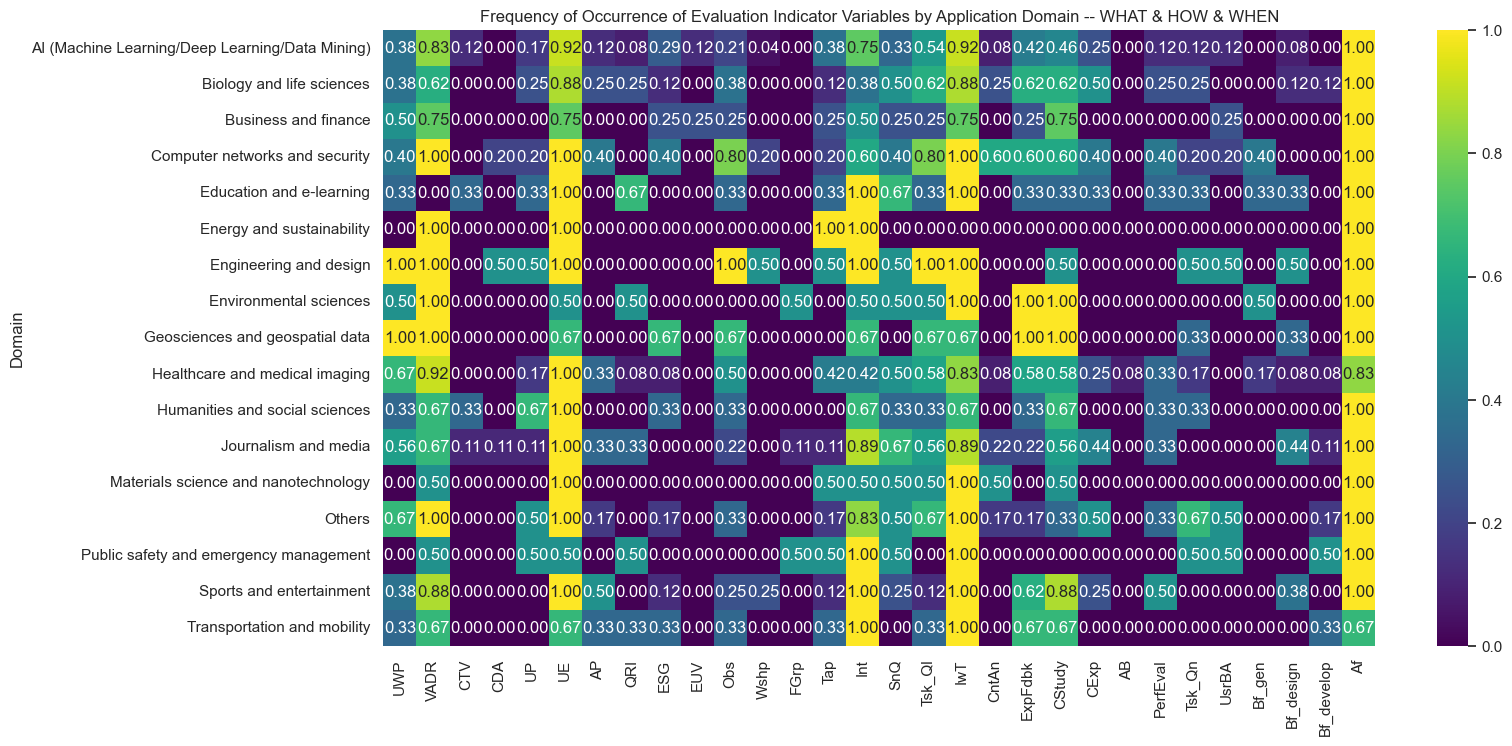

,UWP,VADR,CTV,CDA,UP,UE,AP,QRI,ESG,EUV,...,CStudy,CExp,AB,PerfEval,Tsk_Qn,UsrBA,Bf_gen,Bf_design,Bf_develop,Af
Domain,,,,,,,,,,,,,,,,,,,,,
AI (Machine Learning/Deep Learning/Data Mining),0.375000,0.833333,0.125000,0.000000,0.166667,0.916667,0.125000,0.083333,0.291667,0.125,...,0.458333,0.250000,0.000000,0.125000,0.125000,0.125,0.000000,0.083333,0.000000,1.000000
Biology and life sciences,0.375000,0.625000,0.000000,0.000000,0.250000,0.875000,0.250000,0.250000,0.125000,0.000,...,0.625000,0.500000,0.000000,0.250000,0.250000,0.000,0.000000,0.125000,0.125000,1.000000
Business and finance,0.500000,0.750000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.250,...,0.750000,0.000000,0.000000,0.000000,0.000000,0.250,0.000000,0.000000,0.000000,1.000000
Computer networks and security,0.400000,1.000000,0.000000,0.200000,0.200000,1.000000,0.400000,0.000000,0.400000,0.000,...,0.600000,0.400000,0.000000,0.400000,0.200000,0.200,0.400000,0.000000,0.000000,1.000000
Education and e-learning,0.333333,0.000000,0.333333,0.000000,0.333333,1.000000,0.000000,0.666667,0.000000,0.000,...,0.333333,0.333333,0.000000,0.333333,0.333333,0.000,0.333333,0.333333,0.000000,1.000000
Energy and sustainability,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
Engineering and design,1.000000,1.000000,0.000000,0.500000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000,...,0.500000,0.000000,0.000000,0.000000,0.500000,0.500,0.000000,0.500000,0.000000,1.000000
Environmental sciences,0.500000,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.500000,0.000000,0.000000,1.000000
Geosciences and geospatial data,1.000000,1.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.666667,0.000,...,1.000000,0.000000,0.000000,0.000000,0.333333,0.000,0.000000,0.333333,0.000000,1.000000


In [30]:
# How often papers of a given domain include certain types of evaluation
data_excWHO_binary = pd.concat([y_domain_cleaned, X_domain_binary.iloc[:,5:]], axis=1) #exclude WHO
generateFreqHeatmap(data_excWHO_binary,'Frequency of Occurrence of Evaluation Indicator Variables by Application Domain -- WHAT & HOW & WHEN')

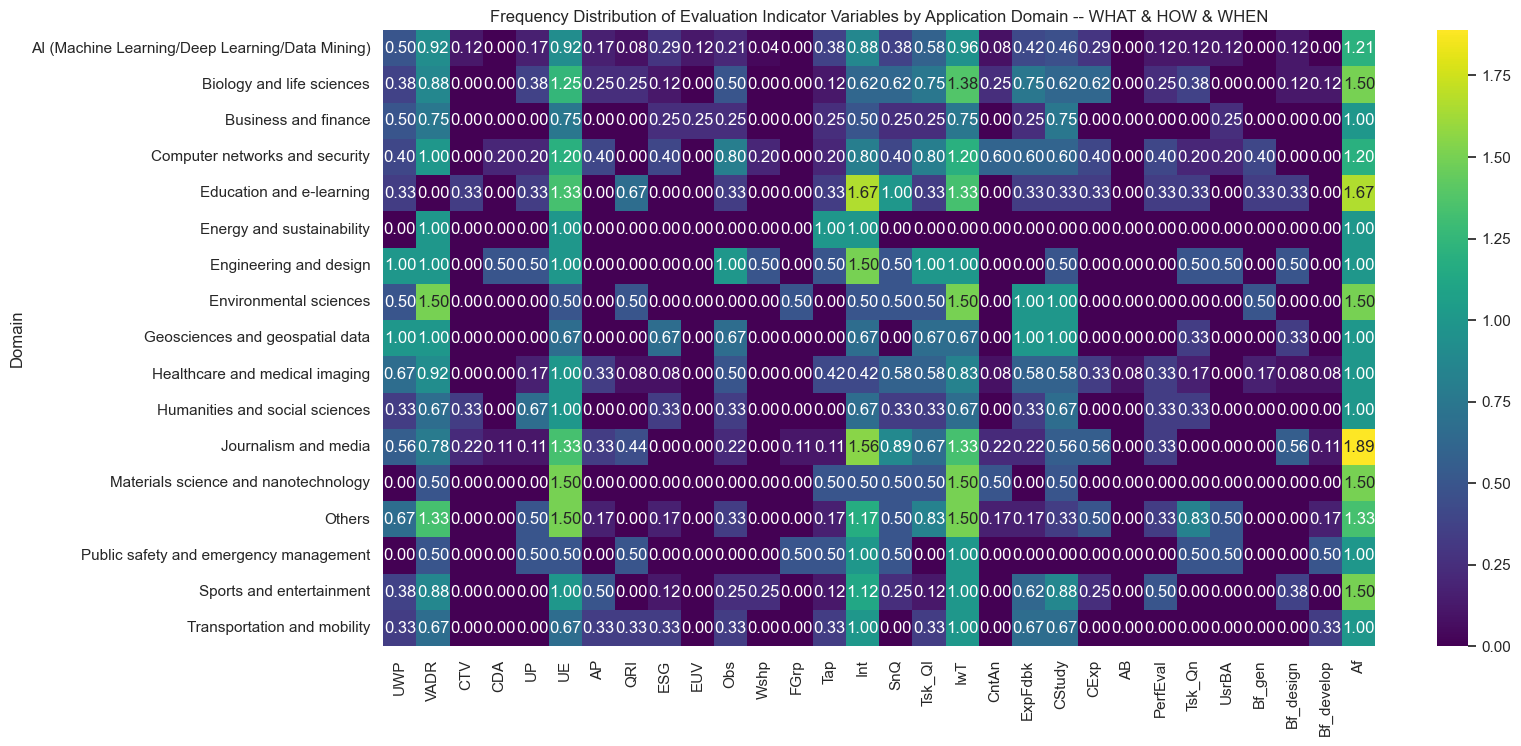

,UWP,VADR,CTV,CDA,UP,UE,AP,QRI,ESG,EUV,...,CStudy,CExp,AB,PerfEval,Tsk_Qn,UsrBA,Bf_gen,Bf_design,Bf_develop,Af
Domain,,,,,,,,,,,,,,,,,,,,,
AI (Machine Learning/Deep Learning/Data Mining),0.500000,0.916667,0.125000,0.000000,0.166667,0.916667,0.166667,0.083333,0.291667,0.125,...,0.458333,0.291667,0.000000,0.125000,0.125000,0.125,0.000000,0.125000,0.000000,1.208333
Biology and life sciences,0.375000,0.875000,0.000000,0.000000,0.375000,1.250000,0.250000,0.250000,0.125000,0.000,...,0.625000,0.625000,0.000000,0.250000,0.375000,0.000,0.000000,0.125000,0.125000,1.500000
Business and finance,0.500000,0.750000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.250,...,0.750000,0.000000,0.000000,0.000000,0.000000,0.250,0.000000,0.000000,0.000000,1.000000
Computer networks and security,0.400000,1.000000,0.000000,0.200000,0.200000,1.200000,0.400000,0.000000,0.400000,0.000,...,0.600000,0.400000,0.000000,0.400000,0.200000,0.200,0.400000,0.000000,0.000000,1.200000
Education and e-learning,0.333333,0.000000,0.333333,0.000000,0.333333,1.333333,0.000000,0.666667,0.000000,0.000,...,0.333333,0.333333,0.000000,0.333333,0.333333,0.000,0.333333,0.333333,0.000000,1.666667
Energy and sustainability,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
Engineering and design,1.000000,1.000000,0.000000,0.500000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000,...,0.500000,0.000000,0.000000,0.000000,0.500000,0.500,0.000000,0.500000,0.000000,1.000000
Environmental sciences,0.500000,1.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.500000,0.000000,0.000000,1.500000
Geosciences and geospatial data,1.000000,1.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.666667,0.000,...,1.000000,0.000000,0.000000,0.000000,0.333333,0.000,0.000000,0.333333,0.000000,1.000000


In [31]:
# Mean amount of evaluations of each type conducted per application domain
generateFreqHeatmap(data_excWHO,'Frequency Distribution of Evaluation Indicator Variables by Application Domain -- WHAT & HOW & WHEN')

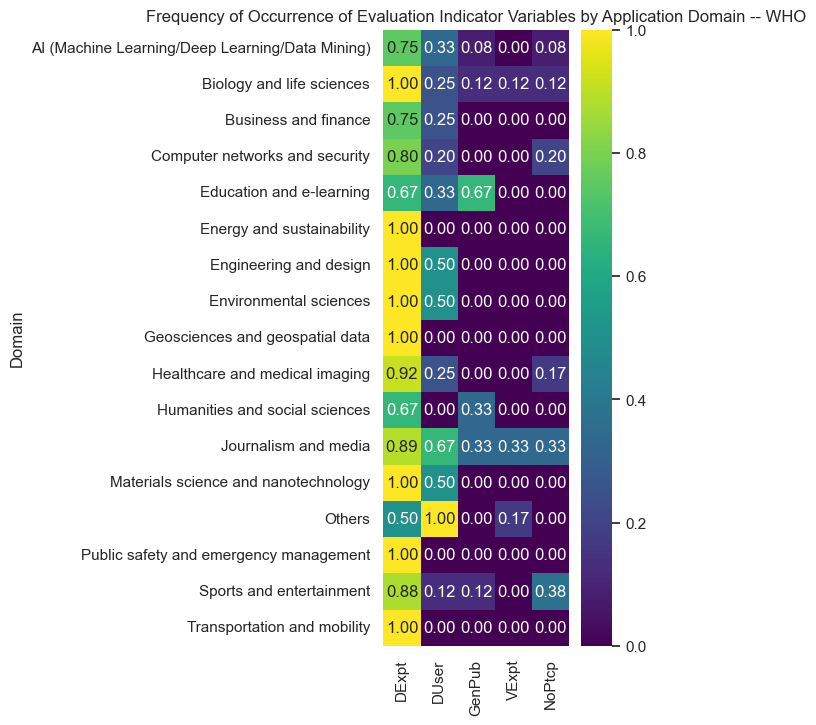

,DExpt,DUser,GenPub,VExpt,NoPtcp
Domain,,,,,
AI (Machine Learning/Deep Learning/Data Mining),0.750000,0.333333,0.083333,0.000000,0.083333
Biology and life sciences,1.000000,0.250000,0.125000,0.125000,0.125000
Business and finance,0.750000,0.250000,0.000000,0.000000,0.000000
Computer networks and security,0.800000,0.200000,0.000000,0.000000,0.200000
Education and e-learning,0.666667,0.333333,0.666667,0.000000,0.000000
Energy and sustainability,1.000000,0.000000,0.000000,0.000000,0.000000
Engineering and design,1.000000,0.500000,0.000000,0.000000,0.000000
Environmental sciences,1.000000,0.500000,0.000000,0.000000,0.000000
Geosciences and geospatial data,1.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
# How often papers of a given domain include certain types of participant in their evaluation
data_incWHO_binary = pd.concat([y_domain_cleaned, X_domain_binary.iloc[:,0:5]], axis=1) #exclude WHO
generateFreqHeatmap(data_incWHO_binary,'Frequency of Occurrence of Evaluation Indicator Variables by Application Domain -- WHO',3)

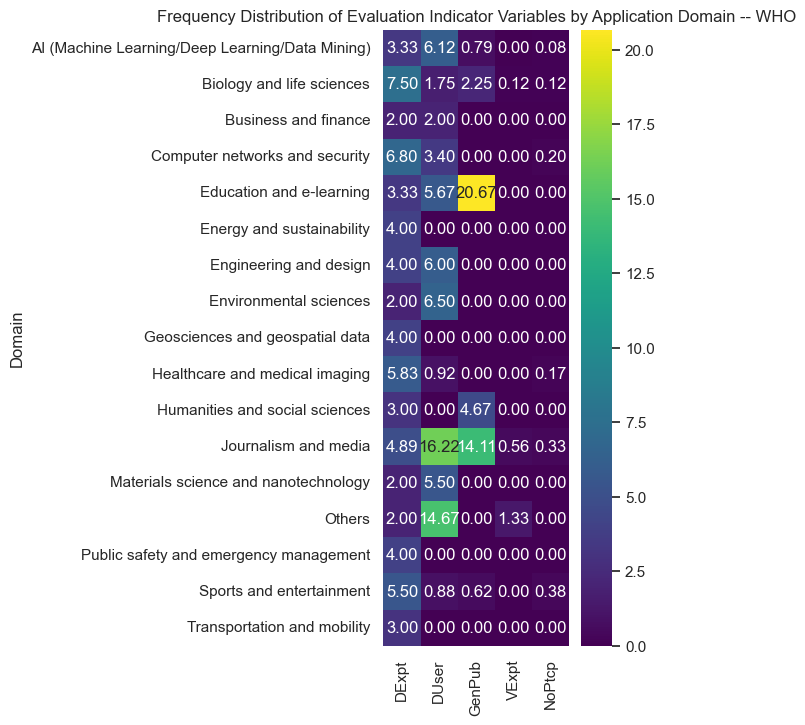

,DExpt,DUser,GenPub,VExpt,NoPtcp
Domain,,,,,
AI (Machine Learning/Deep Learning/Data Mining),3.333333,6.125000,0.791667,0.000000,0.083333
Biology and life sciences,7.500000,1.750000,2.250000,0.125000,0.125000
Business and finance,2.000000,2.000000,0.000000,0.000000,0.000000
Computer networks and security,6.800000,3.400000,0.000000,0.000000,0.200000
Education and e-learning,3.333333,5.666667,20.666667,0.000000,0.000000
Energy and sustainability,4.000000,0.000000,0.000000,0.000000,0.000000
Engineering and design,4.000000,6.000000,0.000000,0.000000,0.000000
Environmental sciences,2.000000,6.500000,0.000000,0.000000,0.000000
Geosciences and geospatial data,4.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
# Mean amount of participants of each type in evaluation sessions per application domain
generateFreqHeatmap(data_incWHO,'Frequency Distribution of Evaluation Indicator Variables by Application Domain -- WHO',3)

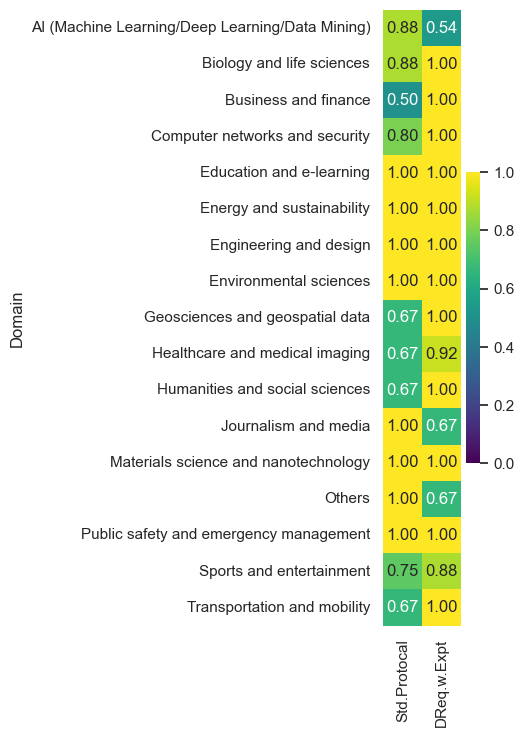

,Std.Protocal,DReq.w.Expt
Domain,,
AI (Machine Learning/Deep Learning/Data Mining),0.875000,0.541667
Biology and life sciences,0.875000,1.000000
Business and finance,0.500000,1.000000
Computer networks and security,0.800000,1.000000
Education and e-learning,1.000000,1.000000
Energy and sustainability,1.000000,1.000000
Engineering and design,1.000000,1.000000
Environmental sciences,1.000000,1.000000
Geosciences and geospatial data,0.666667,1.000000


In [34]:
# Frequency of evaluation protocol and experts involved in domain requirements per application domain
generateFreqHeatmap(data_others,'',1.25)

# Analyze the trend over the years
## 1. Each domain count by year(stacked bar chart)
## 2. VIS4AI, VIS4VIS, Immersive works count by year (line chart)
## 3. Evaluation sessions average by year (line chart)
## 4. HOW (evluation scenerios) occurances by year (line chart)

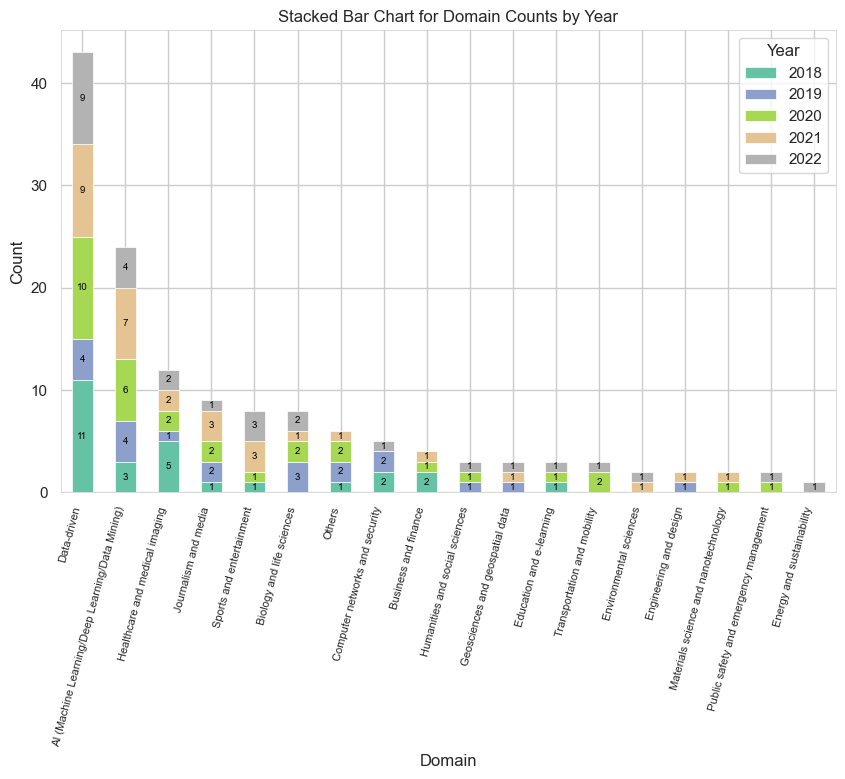

In [35]:
# 1) Domain Count by Year

#Domain = strimmedWhole['Domain'].str.replace(r'^\d+\.\s*', '', regex=True)
#Year = strimmedWhole['VIS year']
#DTrend = pd.concat([Domain,Year], axis=1)

DTrend_domain = pd.concat([y_domain_cleaned,strimmedWhole['VIS year'][strimmedWhole['Data-Driven']==0].fillna(0)], axis=1)
DataDriven=strimmedWhole[['Data-Driven','VIS year']][strimmedWhole['Data-Driven']==1]
DataDriven['Data-Driven']='Data-driven'
DataDriven.columns = ['Domain','VIS year']
DTrend = pd.concat([DTrend_domain,DataDriven],axis=0)

pivot_data = DTrend.pivot_table(index='Domain', columns='VIS year', aggfunc='size', fill_value=0)
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values(by='Total', ascending=False).drop(columns='Total')

sns.set(style="whitegrid")

cmap = plt.get_cmap("Set2")

ax = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap=cmap, linewidth=0.5)

plt.xlabel('Domain')
plt.ylabel('Count')
plt.title('Stacked Bar Chart for Domain Counts by Year')
plt.legend(title='Year', loc='upper right', labels=[int(label) for label in pivot_data.columns])

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=7, color='black', fmt='%d', labels=[int(val) if val != 0 else '' for val in container.datavalues])

plt.xticks(rotation=75, ha='right', fontsize=8)
ax.margins(x=0)

ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

plt.show()


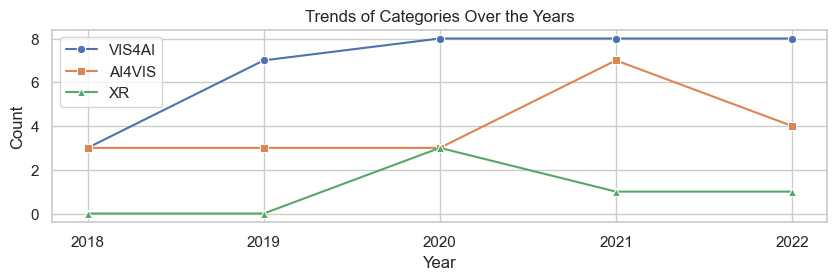

In [36]:
# 2) VIS4AI, VIS4VIS, Immersive works count by year (line chart)
PTrend =  strimmedWhole[['VIS year','VIS4AI','AI4VIS','XR']]
PTrend['VIS year'] = PTrend['VIS year'].astype(int)

trend_data = PTrend.groupby('VIS year').sum().reset_index()

sns.set(style="whitegrid")

years_to_display = [2018, 2019, 2020, 2021, 2022]

trend_data_filtered = trend_data[trend_data['VIS year'].isin(years_to_display)]

plt.figure(figsize=(10, 2.5))
sns.lineplot(x='VIS year', y='VIS4AI', data=trend_data_filtered, label='VIS4AI', marker='o')
sns.lineplot(x='VIS year', y='AI4VIS', data=trend_data_filtered, label='AI4VIS', marker='s')
sns.lineplot(x='VIS year', y='XR', data=trend_data_filtered, label='XR', marker='^')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trends of Categories Over the Years')
plt.xticks(years_to_display)  
plt.legend()
plt.grid(True)

plt.show()


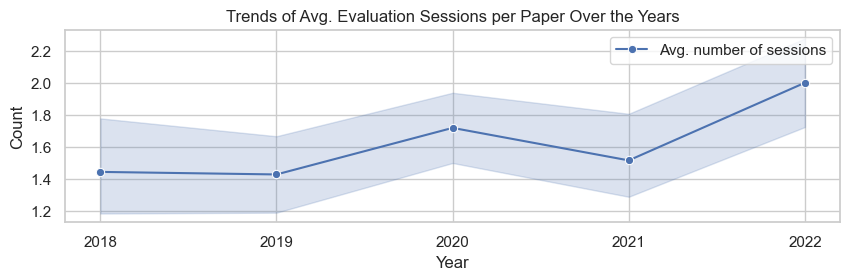

In [37]:
# 3) Evaluation sessions average by year
STrend =  strimmedWhole[['VIS year','N.o.Session']]
STrend['VIS year'] = STrend['VIS year'].astype(int)

Strend_data = STrend.groupby('VIS year').mean().reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 2.5))
sns.lineplot(x='VIS year', y='N.o.Session', data=STrend, label='Avg. number of sessions', marker='o')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trends of Avg. Evaluation Sessions per Paper Over the Years')
plt.xticks(years_to_display) 
plt.legend()
plt.grid(True)

plt.show()

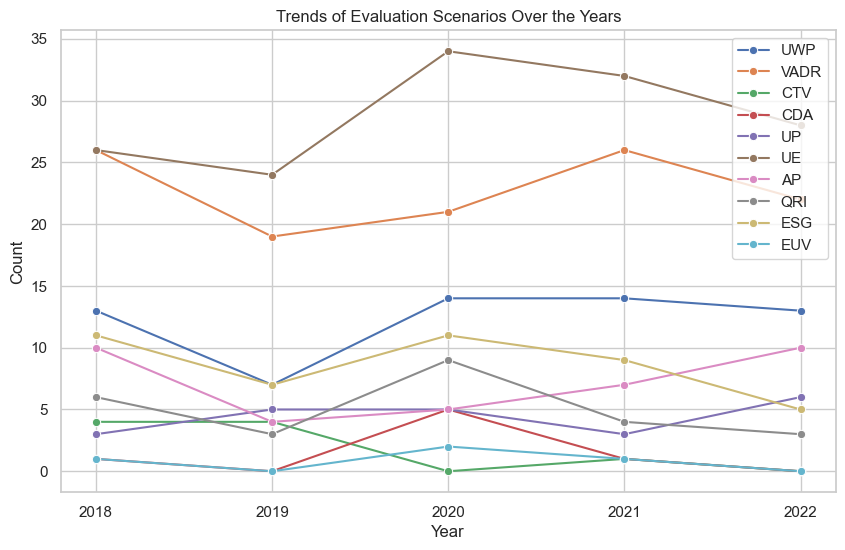

In [38]:
# 4.1) HOW (evaluation scenerios) occurrences by year
HowTrend =  strimmedWhole[['VIS year','UWP','VADR', 'CTV', 'CDA', 'UP', 'UE', 'AP', 'QRI', 'ESG', 'EUV']]
HowTrend['VIS year'] = HowTrend['VIS year'].astype(int)

howtrend_data = HowTrend.groupby('VIS year').sum().reset_index()

sns.set(style="whitegrid")

years_to_display = [2018, 2019, 2020, 2021, 2022]

howtrend_data_filtered = howtrend_data[howtrend_data['VIS year'].isin(years_to_display)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='VIS year', y='UWP', data=howtrend_data_filtered, label='UWP', marker='o')
sns.lineplot(x='VIS year', y='VADR', data=howtrend_data_filtered, label='VADR', marker='o')
sns.lineplot(x='VIS year', y='CTV', data=howtrend_data_filtered, label='CTV', marker='o')
sns.lineplot(x='VIS year', y='CDA', data=howtrend_data_filtered, label='CDA', marker='o')
sns.lineplot(x='VIS year', y='UP', data=howtrend_data_filtered, label='UP', marker='o')
sns.lineplot(x='VIS year', y='UE', data=howtrend_data_filtered, label='UE', marker='o')
sns.lineplot(x='VIS year', y='AP', data=howtrend_data_filtered, label='AP', marker='o')
sns.lineplot(x='VIS year', y='QRI', data=howtrend_data_filtered, label='QRI', marker='o')
sns.lineplot(x='VIS year', y='ESG', data=howtrend_data_filtered, label='ESG', marker='o')
sns.lineplot(x='VIS year', y='EUV', data=howtrend_data_filtered, label='EUV', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trends of Evaluation Scenarios Over the Years')
plt.xticks(years_to_display)  
plt.legend()
plt.grid(True)

plt.show()

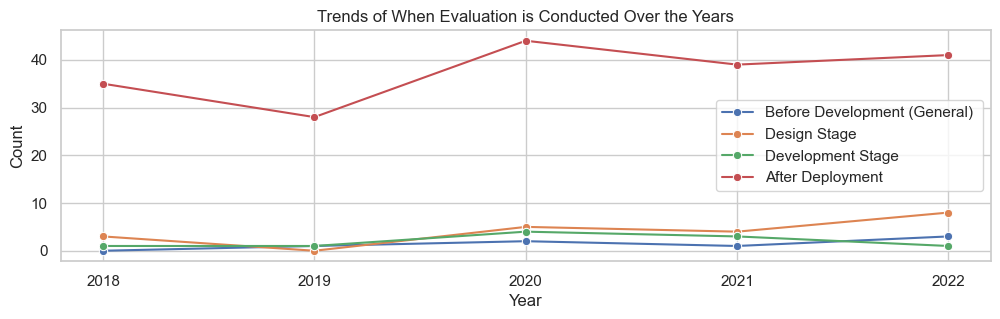

In [39]:
# 4.2) WHEN occurrences by year
WhenTrend =  strimmedWhole[['VIS year','Bf_gen', 'Bf_design', 'Bf_develop', 'Af']]
WhenTrend['VIS year'] = WhenTrend['VIS year'].astype(int)

whentrend_data = WhenTrend.groupby('VIS year').sum().reset_index()

sns.set(style="whitegrid")

years_to_display = [2018, 2019, 2020, 2021, 2022]

whentrend_data_filtered = whentrend_data[whentrend_data['VIS year'].isin(years_to_display)]

plt.figure(figsize=(12, 3))
sns.lineplot(x='VIS year', y='Bf_gen', data=whentrend_data_filtered, label='Before Development (General) ', marker='o')
sns.lineplot(x='VIS year', y='Bf_design', data=whentrend_data_filtered, label='Design Stage', marker='o')
sns.lineplot(x='VIS year', y='Bf_develop', data=whentrend_data_filtered, label='Development Stage', marker='o')
sns.lineplot(x='VIS year', y='Af', data=whentrend_data_filtered, label='After Deployment', marker='o')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trends of When Evaluation is Conducted Over the Years')
plt.xticks(years_to_display) 
plt.legend()
plt.grid(True)

plt.show()

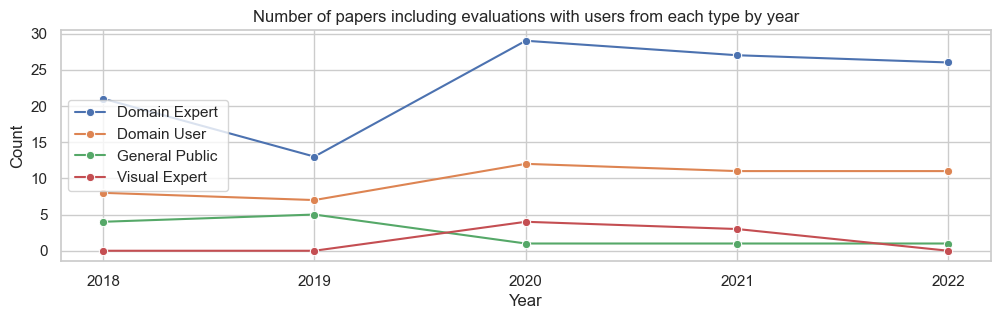

In [40]:
# 4.3) WHO occurrences by year
WhoTrend =  strimmedWhole[['VIS year','DExpt', 'DUser', 'GenPub', 'VExpt', 'NoPtcp']]
WhoTrend['VIS year'] = WhoTrend['VIS year'].astype(int)

whotrend_data0 = WhoTrend.apply(lambda x: np.clip(x,a_min=0,a_max=1))
whotrend_data0['VIS year'] = WhoTrend['VIS year']
whotrend_data0 = whotrend_data0.groupby('VIS year').sum().reset_index()

sns.set(style="whitegrid")

years_to_display = [2018, 2019, 2020, 2021, 2022]

whotrend_data0_filtered = whotrend_data0[whotrend_data0['VIS year'].isin(years_to_display)]

plt.figure(figsize=(12, 3))
sns.lineplot(x='VIS year', y='DExpt', data=whotrend_data0_filtered, label='Domain Expert ', marker='o')
sns.lineplot(x='VIS year', y='DUser', data=whotrend_data0_filtered, label='Domain User', marker='o')
sns.lineplot(x='VIS year', y='GenPub', data=whotrend_data0_filtered, label='General Public', marker='o')
sns.lineplot(x='VIS year', y='VExpt', data=whotrend_data0_filtered, label='Visual Expert', marker='o')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of papers including evaluations with users from each type by year')
plt.xticks(years_to_display)  
plt.legend()
plt.grid(True)

plt.show()

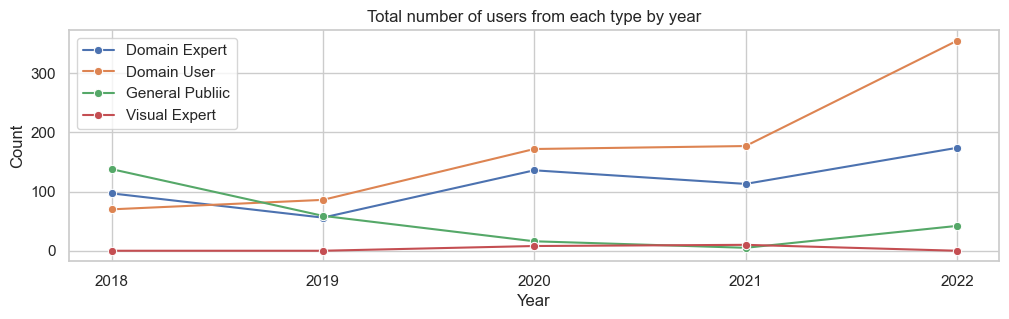

In [41]:
# 4.3) WHO occurrences by year 2
WhoTrend =  strimmedWhole[['VIS year','DExpt', 'DUser', 'GenPub', 'VExpt', 'NoPtcp']]
WhoTrend['VIS year'] = WhoTrend['VIS year'].astype(int)

whotrend_data1 = WhoTrend.groupby('VIS year').sum().reset_index()

sns.set(style="whitegrid")

years_to_display = [2018, 2019, 2020, 2021, 2022]

whotrend_data1_filtered = whotrend_data1[whotrend_data1['VIS year'].isin(years_to_display)]

plt.figure(figsize=(12, 3))
sns.lineplot(x='VIS year', y='DExpt', data=whotrend_data1_filtered, label='Domain Expert ', marker='o')
sns.lineplot(x='VIS year', y='DUser', data=whotrend_data1_filtered, label='Domain User', marker='o')
sns.lineplot(x='VIS year', y='GenPub', data=whotrend_data1_filtered, label='General Publiic', marker='o')
sns.lineplot(x='VIS year', y='VExpt', data=whotrend_data1_filtered, label='Visual Expert', marker='o')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total number of users from each type by year')
plt.xticks(years_to_display)  
plt.legend()
plt.grid(True)

plt.show()

In [42]:
# set band range
bins = [0, 10, 20, 30, 40, 50, 100, float('inf')]

for column in WhoTrend.columns[1:]:
    WhoTrend[f'{column}_range'] = pd.cut(WhoTrend[column], bins=bins, labels=['1-10', '11-20', '21-30', '31-40', '41-50', '51-100', '100+'])


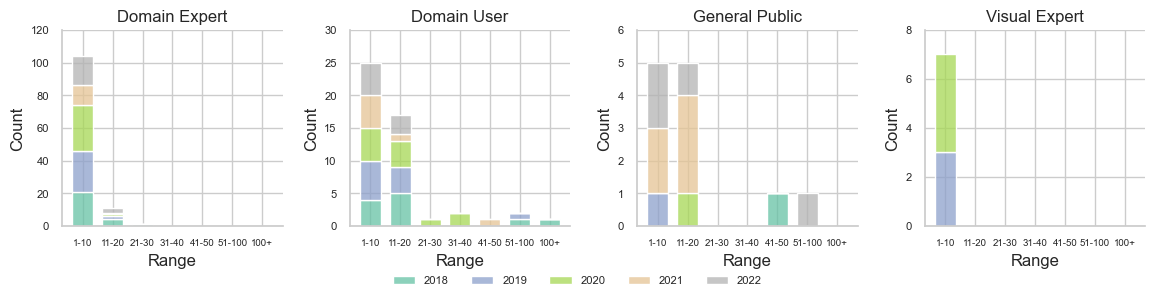

In [43]:
test = WhoTrend.iloc[:,[0,6,7,8,9]]
df = pd.DataFrame(test)
# convert to Categorical variable
df['DExpt_range'] = pd.Categorical(df['DExpt_range'], categories=['1-10', '11-20', '21-30', '31-40', '41-50', '51-100', '100+'])
df['DUser_range'] = pd.Categorical(df['DUser_range'], categories=['1-10', '11-20', '21-30', '31-40', '41-50', '51-100', '100+'])
df['GenPub_range'] = pd.Categorical(df['GenPub_range'], categories=['1-10', '11-20', '21-30', '31-40', '41-50', '51-100', '100+'])
df['VExpt_range'] = pd.Categorical(df['VExpt_range'], categories=['1-10', '11-20', '21-30', '31-40', '41-50', '51-100', '100+'])
df.columns = ['Year','Domain Expert','Domain User','General Public','Visual Expert']

df_melted = pd.melt(df, id_vars=['Year'], var_name='Variable', value_name='Range')

# draw FacetGrid
cmap = plt.get_cmap("Set2")
color_indices = [7, 6, 4, 2, 0]
selected_colors = [cmap(i) for i in color_indices]
g = sns.FacetGrid(df_melted, col='Variable', sharey=False)
g.map_dataframe(sns.histplot, x='Range', hue='Year', multiple='stack', shrink=0.7, binwidth=1.5, palette=selected_colors)
g.set_xticklabels(fontsize = 7)
g.set_yticklabels(fontsize = 8)
g.set_titles(col_template="{col_name}", fontsize=9)
g.add_legend(loc='lower center', labels=[int(label) for label in df['Year'].unique()],ncol=5, fontsize = 8)

plt.show()